<a href="https://colab.research.google.com/github/vishva2410/Deep-Learning-Projects-Part-A-/blob/main/Lung_cancer_prediction(Complicated_CNN_and_MobileNetV2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
pip install fastapi uvicorn python-multipart

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.6 MB/s eta 0:00:00


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from glob import glob
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,accuracy_score,roc_curve, auc
import seaborn as sns
from fastapi import FastAPI, UploadFile, File
from io import BytesIO
from PIL import Image

In [2]:
with ZipFile('Lung_cancer.zip', 'r') as zipObj:
   zipObj.extractall()
   print('The data set has been extracted.')

The data set has been extracted.


In [4]:
extracted_folder = "/content/Lung_cancer"
classes = os.listdir(extracted_folder)
print(os.listdir(extracted_folder))

['Normal cases', 'Test cases', '.DS_Store', 'Malignant cases', 'Bengin cases']


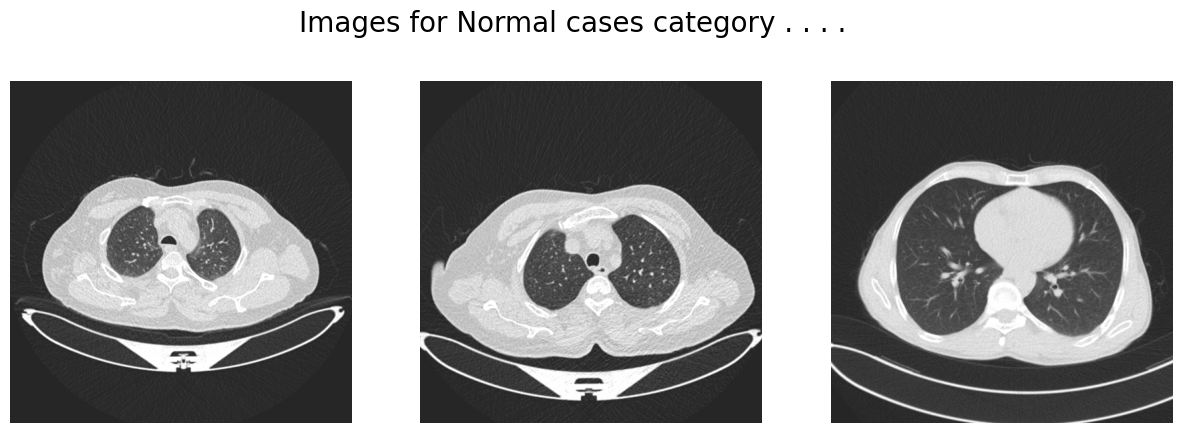

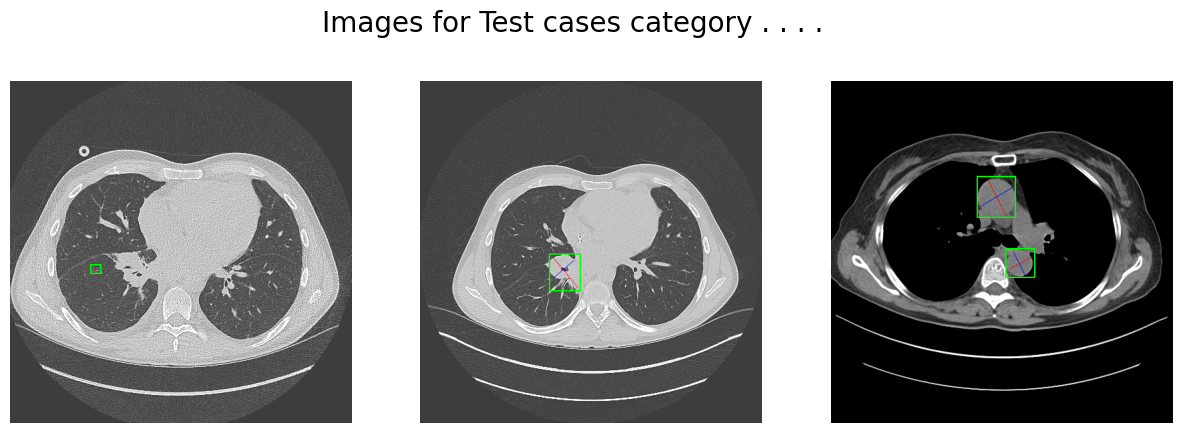

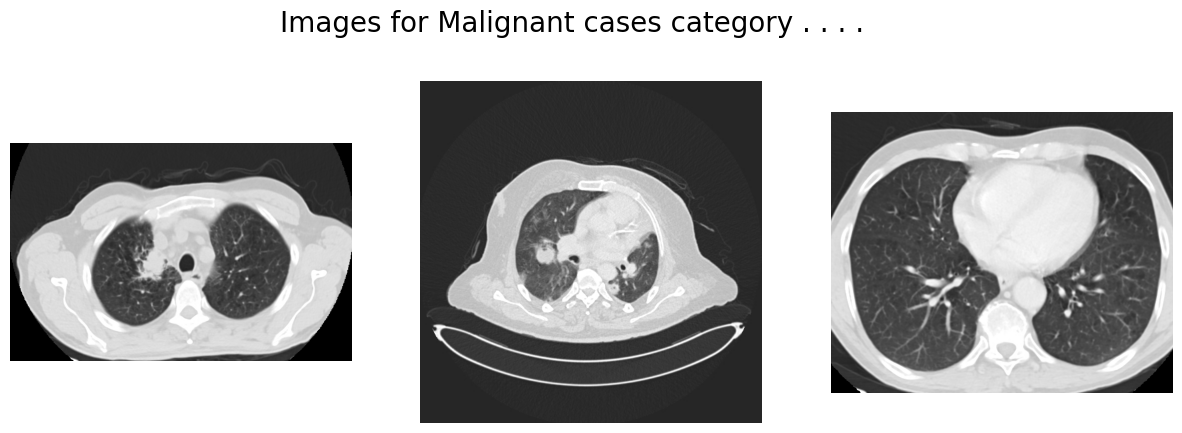

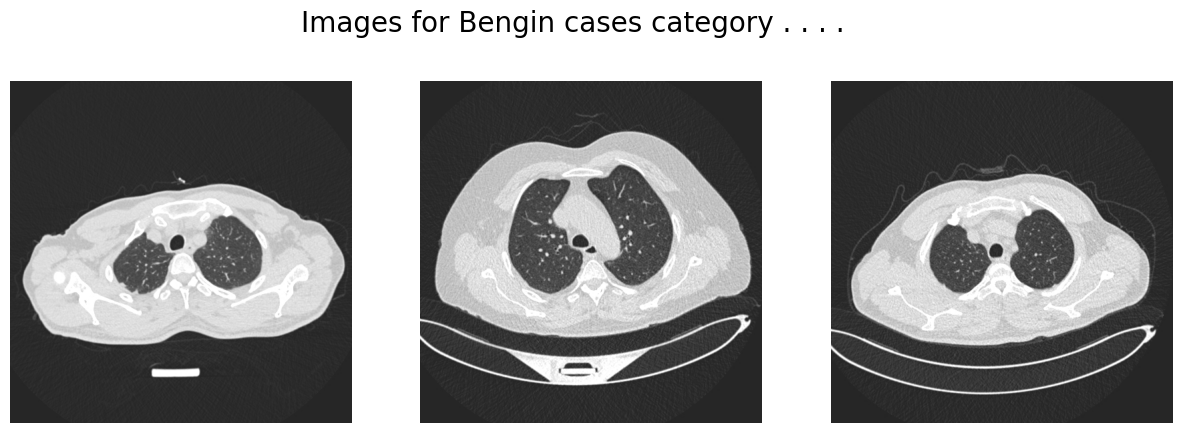

In [5]:
for cat in classes:
    if cat != ".DS_Store":
        image_dir = f'{extracted_folder}/{cat}'
        images = os.listdir(image_dir)
        images = [img for img in images if os.path.isfile(os.path.join(image_dir, img))]

        fig, ax = plt.subplots(1, 3, figsize = (15, 5))
        fig.suptitle(f'Images for {cat} category . . . .',
                     fontsize = 20)

        for i in range(3):
            if images:
                k = np.random.randint(0, len(images))
                img = np.array(Image.open(f'{extracted_folder}/{cat}/{images[k]}'))
                ax[i].imshow(img)
                ax[i].axis('off')
            else:
                print(f"No images found in directory: {image_dir}")
        plt.show()

In [24]:
train_folders = ["/content/Lung_cancer/Bengin cases", "/content/Lung_cancer/Malignant cases", "/content/Lung_cancer/Normal cases"]
test_folder = "/content/Lung_cancer/Test cases"

IMG_SIZE = 256
SPLIT = 0.2

X_train, Y_train = [], []
X_test, Y_test = [], []

classes = ["Bengin", "Malignant", "Normal"]

for train_path in train_folders:
    for i, cat in enumerate(classes):

        images = glob(f"{train_path}/{cat}/*.jpg")
        for image in images:
            img = cv2.imread(image)
            if img is not None:
                X_train.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
                Y_train.append(i)
            else:
                print(f"Failed to load image: {image}")

for i, cat in enumerate(classes):
    images = glob(f"{test_folder}/{cat}/*.jpg")
    for image in images:
        img = cv2.imread(image)
        if img is not None:
            X_test.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
            Y_test.append(i)
        else:
            print(f"Failed to load image: {image}")


X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

Y_train = to_categorical(Y_train, num_classes=len(classes))
Y_test = to_categorical(Y_test, num_classes=len(classes))



In [25]:
Y_train.shape

(0, 3)

In [26]:
import os

for path in train_folders + [test_folder]:
    print(f"Checking {path}: Exists - {os.path.exists(path)}")


Checking /content/Lung_cancer/Bengin cases: Exists - True
Checking /content/Lung_cancer/Malignant cases: Exists - True
Checking /content/Lung_cancer/Normal cases: Exists - True
Checking /content/Lung_cancer/Test cases: Exists - True


In [27]:
train_folders = ["/content/Lung_cancer/Bengin cases",
                 "/content/Lung_cancer/Malignant cases",
                 "/content/Lung_cancer/Normal cases"]
test_folder = "/content/Lung_cancer/Test cases"

IMG_SIZE = 256
SPLIT = 0.2

X_train, Y_train = [], []
X_test, Y_test = [], []

# No need to iterate over 'classes' since each train_folders path already corresponds to a class
for i, train_path in enumerate(train_folders):
    images = glob(f"{train_path}/*.*")  # Match all image types
    print(f"Found {len(images)} images in {train_path}")

    for image in images:
        img = cv2.imread(image)
        if img is not None:
            X_train.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
            Y_train.append(i)
        else:
            print(f"Failed to load image: {image}")

for i, cat in enumerate(classes):
    images = glob(f"{test_folder}/{cat}/*.*")
    print(f"Found {len(images)} images in {test_folder}/{cat}")

    for image in images:
        img = cv2.imread(image)
        if img is not None:
            X_test.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
            Y_test.append(i)
        else:
            print(f"Failed to load image: {image}")

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

Y_train = to_categorical(Y_train, num_classes=len(classes))
Y_test = to_categorical(Y_test, num_classes=len(classes))

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=SPLIT, random_state=42)

Found 120 images in /content/Lung_cancer/Bengin cases
Found 561 images in /content/Lung_cancer/Malignant cases
Found 416 images in /content/Lung_cancer/Normal cases
Found 0 images in /content/Lung_cancer/Test cases/Bengin
Found 0 images in /content/Lung_cancer/Test cases/Malignant
Found 0 images in /content/Lung_cancer/Test cases/Normal


In [28]:
Y_train.shape

(877, 256, 256, 3)

In [32]:
x_test = []
test_images = glob(f"{test_folder}/*.*")  # Match all image formats
print(f"Found {len(test_images)} images in {test_folder}")

for image in test_images:
    img = cv2.imread(image)
    if img is not None:
        x_test.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    else:
        print(f"Failed to load image: {image}")

x_test = np.array(x_test)

Found 197 images in /content/Lung_cancer/Test cases


In [102]:
num_bengin = 50
num_malignant = 70
num_normal = 77

y_test = (
    [0] * num_bengin +  # First 50 images: Bengin (Class 0)
    [1] * num_malignant +  # Next 70 images: Malignant (Class 1)
    [2] * num_normal  # Last 77 images: Normal (Class 2)
)

y_test = np.array(y_test)
y_test = to_categorical(y_test, num_classes=3)

print(f"y_test shape: {y_test.shape}")


y_test shape: (197, 3)


In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │              

 Total params: 44,545,611 (169.93 MB)

 Trainable params: 14,848,259 (56.64 MB)

 Non-trainable params: 832 (3.25 KB)

 Optimizer params: 29,696,520 (113.28 MB)

In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
model.fit(X_train, Y_train, epochs=8, validation_data=(X_val, Y_val))

Epoch 1/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 271s 9s/step - accuracy: 0.4741 - loss: 1.4780 - val_accuracy: 0.1500 - val_loss: 10.1437
Epoch 2/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 331s 10s/step - accuracy: 0.7166 - loss: 0.6520 - val_accuracy: 0.3364 - val_loss: 3.9298
Epoch 3/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 307s 9s/step - accuracy: 0.8035 - loss: 0.4834 - val_accuracy: 0.4273 - val_loss: 1.6250
Epoch 4/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 272s 10s/step - accuracy: 0.8592 - loss: 0.3377 - val_accuracy: 0.5318 - val_loss: 1.3350
Epoch 5/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 284s 10s/step - accuracy: 0.8693 - loss: 0.3158 - val_accuracy: 0.7727 - val_loss: 0.9712
Epoch 6/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 267s 10s/step - accuracy: 0.8867 - loss: 0.2758 - val_accuracy: 0.6864 - val_loss: 1.3974
Epoch 7/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 329s 10s/step - accuracy: 0.9198 - loss: 0.2219 - val_accuracy: 0.7818 - val_loss: 1.1958
Epoch 8/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 323s 10s/step - accuracy: 0.9209 - loss: 0.2220 - val_accuracy: 0.6182 - va

In [87]:
y_pred = model.predict(x_test)
print(y_pred.shape)


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
(197, 3)


In [51]:
model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model2.trainable = False

model2 = tf.keras.Sequential([
    model2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<ipython-input-51-dfd1d64a1452>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [53]:
model2.fit(X_train, Y_train, epochs=8, validation_data=(X_val, Y_val))

Epoch 1/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8914 - loss: 0.3089 - val_accuracy: 0.8636 - val_loss: 0.3304
Epoch 2/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.8895 - loss: 0.3116 - val_accuracy: 0.8818 - val_loss: 0.3184
Epoch 3/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9170 - loss: 0.2512 - val_accuracy: 0.9045 - val_loss: 0.3078
Epoch 4/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9102 - loss: 0.2563 - val_accuracy: 0.8818 - val_loss: 0.2911
Epoch 5/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9101 - loss: 0.2599 - val_accuracy: 0.8955 - val_loss: 0.2892
Epoch 6/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9152 - loss: 0.2428 - val_accuracy: 0.8909 - val_loss: 0.2852
Epoch 7/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9216 - loss: 0.2291 - val_accuracy: 0.9000 - val_loss: 0.2770
Epoch 8/8
28/28 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.9317 - loss: 0.2220 - val_accuracy: 0.8909 - val_loss: 0.2800

In [88]:
y_pred2 = model2.predict(x_test)
print(y_pred2.shape)

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
(197, 3)


In [92]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred2_labels = np.argmax(y_pred2, axis=1)

In [105]:
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot to single-label indices

accuracy_model1 = accuracy_score(y_test_labels, y_pred2_labels)
accuracy_model2 = accuracy_score(y_test_labels, y_pred_labels)

print(f"Custom CNN Accuracy: {accuracy_model1:.4f}")
print(f"Pretrained Model Accuracy: {accuracy_model2:.4f}")


Custom CNN Accuracy: 0.3807
Pretrained Model Accuracy: 0.3756


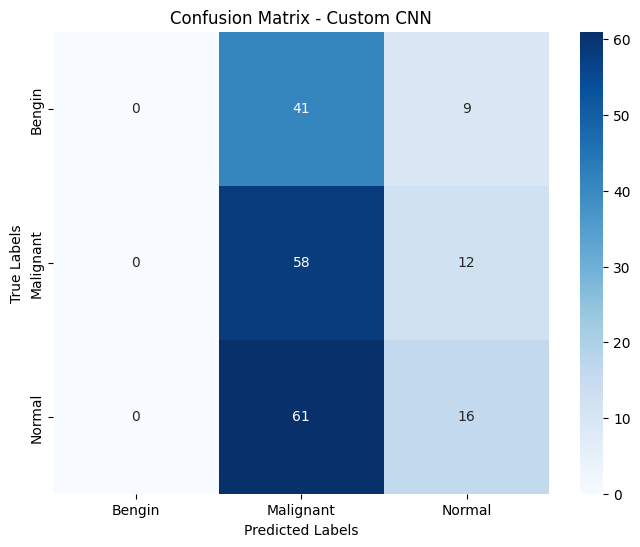

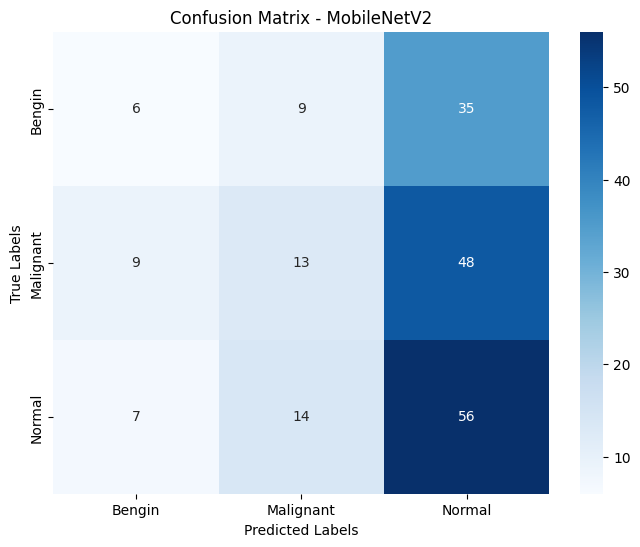

Classification Report - Custom CNN:
               precision    recall  f1-score   support

      Bengin       0.00      0.00      0.00        50
   Malignant       0.36      0.83      0.50        70
      Normal       0.43      0.21      0.28        77

    accuracy                           0.38       197
   macro avg       0.26      0.35      0.26       197
weighted avg       0.30      0.38      0.29       197

Classification Report - MobileNetV2:
               precision    recall  f1-score   support

      Bengin       0.27      0.12      0.17        50
   Malignant       0.36      0.19      0.25        70
      Normal       0.40      0.73      0.52        77

    accuracy                           0.38       197
   macro avg       0.35      0.34      0.31       197
weighted avg       0.36      0.38      0.33       197



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


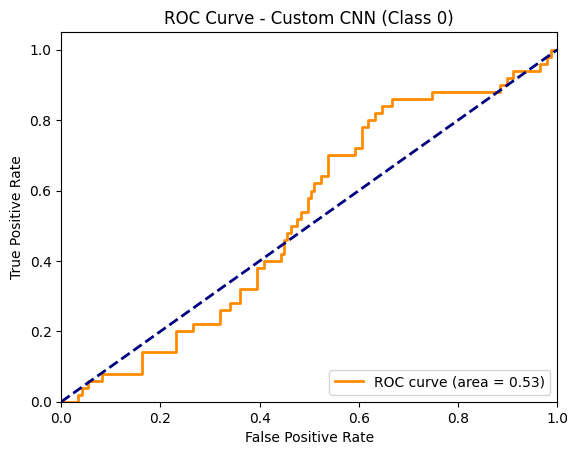

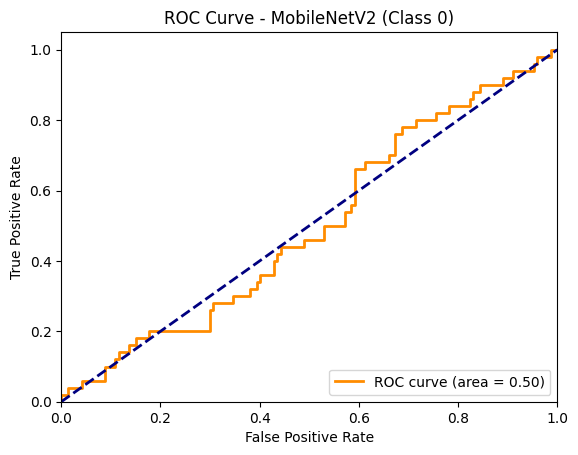

In [108]:

cm1 = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Custom CNN")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

cm2 = confusion_matrix(y_test_labels, y_pred2_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - MobileNetV2")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


print("Classification Report - Custom CNN:\n", classification_report(y_test_labels, y_pred_labels, target_names=classes))
print("Classification Report - MobileNetV2:\n", classification_report(y_test_labels, y_pred2_labels, target_names=classes))

fpr, tpr, thresholds = roc_curve(y_test[:, 0], y_pred[:, 0])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Custom CNN (Class 0)')
plt.legend(loc="lower right")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test[:, 0], y_pred2[:, 0])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MobileNetV2 (Class 0)')
plt.legend(loc="lower right")
plt.show()


In [111]:
model.save("lung_cancer_model_cnn.h5")
model2.save("lung_cancer_model_mobilenetv2.h5")